In [59]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

In [60]:
import pandas as pd
import numpy as np
from src.models import fit_ols, extract_coefficients
from src.config import DATA_PROCESSED

## Análise da Regressão Linear

In [61]:
df = pd.read_csv(DATA_PROCESSED / "base_analitica.csv", parse_dates=["date"])

y = "demanda_energia"

X = [
    "tarifa_energia_real",
    "pib_real",
    "importacoes_petroleo",
    "d_2001",
    "d_2006",
    "d_2008",
    "d_2020"
]

results = fit_ols(df, y, X)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        demanda_energia   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     282.7
Date:                Thu, 15 Jan 2026   Prob (F-statistic):          3.95e-137
Time:                        16:56:47   Log-Likelihood:                -5182.5
No. Observations:                 346   AIC:                         1.038e+04
Df Residuals:                     338   BIC:                         1.041e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.135e+06 

## Indícios

- Alta probabilidade do modelo ter um alto grau de Multicolinearidade conforme sugerido na nota o que altera drasticamente os coeficientes das variáveis independentes
-  ALta probabilidade de ter autocorrelação dos resíduos, pelo baixo valor do "d" de Durbin Watson 


In [62]:
df_log = df.copy()
df_log["ln_demanda"] = np.log(df_log["demanda_energia"])
df_log["ln_tarifa"] = np.log(df_log["tarifa_energia_real"]) 
df_log["ln_pib"] = np.log(df_log["pib_real"]) 
df_log["ln_importacoes"] = np.log(df_log["importacoes_petroleo"])

In [63]:
y_log = "ln_demanda"

X_log = [
    "ln_tarifa",
    "ln_pib",
    "ln_importacoes",
    "d_2001",
    "d_2006",
    "d_2008",
    "d_2020"
]

results = fit_ols(df_log, y_log, X_log)

print(results_log.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_demanda   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     408.1
Date:                Thu, 15 Jan 2026   Prob (F-statistic):          1.20e-160
Time:                        16:56:47   Log-Likelihood:                 534.53
No. Observations:                 346   AIC:                            -1053.
Df Residuals:                     338   BIC:                            -1022.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.9793      0.257     46.

## Análise gráfica dos valores ajustados

<Axes: >

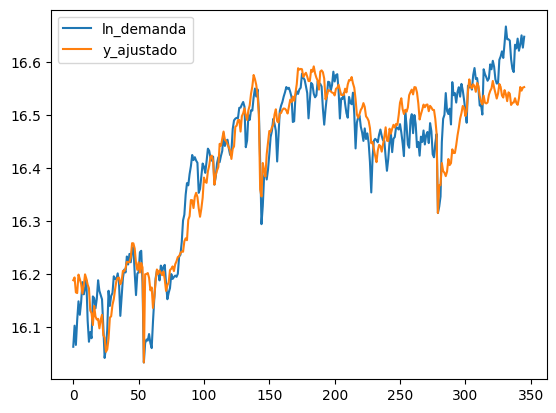

In [64]:
from src.models import fitted_values

df_log["y_ajustado"] = fitted_values(results_log)
df_log[["ln_demanda", "y_ajustado"]].plot()

In [65]:
from src.models import residuals

df_log["resid"] = residuals(results_log)

In [68]:
import importlib
importlib.reload(diagnostics)

from src.diagnostics import (
    run_all_diagnostics,
    calculate_vif
)

diagnostics_df = run_all_diagnostics(results_log)
vif_df = calculate_vif(results_log)

diagnostics_df


,test,statistic,p_value,skewness,kurtosis,f_stat,f_p_value,lags,lm_stat,lm_p_value,resultado
0,Jarque-Bera,2.718699,2.568278e-01,0.217948,0.032618,NaN,NaN,NaN,NaN,NaN,Dados com normalidade
1,Durbin-Watson,0.311561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Resultado indefinido
2,Breusch-Godfrey,242.310210,1.233066e-54,NaN,NaN,787.527306,3.402522e-90,1.0,NaN,NaN,Com autocorrelação
3,Breusch-Pagan,NaN,NaN,NaN,NaN,2.312173,2.580243e-02,NaN,15.811170,0.026899,Dados Heterocedásticos
4,White,NaN,NaN,NaN,NaN,3.620254,1.314546e-05,NaN,45.945155,0.000029,Dados Heterocedásticos


In [69]:
vif_df

,variavel,vif,resultado
0,ln_tarifa,2335.043222,Multicolinearidade severa
1,ln_pib,2303.641553,Multicolinearidade severa
2,ln_importacoes,71.452400,Multicolinearidade severa
3,d_2001,1.006560,Sem multicolinearidade
4,d_2006,1.012214,Sem multicolinearidade
5,d_2008,1.009758,Sem multicolinearidade
6,d_2020,1.008121,Sem multicolinearidade


## O Modelo está especificado de forma incorreta pois: 
- Quebra a Hipótese de AUtocorrelação
- Quebra a Hipótese de Homocedasticidade dos resíduos (facilmente ajustada com correção de erros robustos)
- Quebra a hipótese de Multicolinearidade
- Apenas a hipótese de normalidade é atendida